In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
from PIL import UnidentifiedImageError

### Excercise:

David Hunter Hubel and Torsten Wiesel earned a Nobel Prize in 1981 for his experimental work with the cortex of an anesthetized cat. 

By and large, they discovered that each neuron in the primary visual cortex concentrates on exclusively processing a small, specific portion or patch of the visual field (and nothing else). It is as if the neuron is linked to that single visual patch. So, it only responds to visual stimuli presented exclusively there. But, additionally, it does not respond to any stimulus there, but only to specific ones. This is, the neuron only fires when it detects one (1) particular pattern in one (1) particular area of the visual field. [See this video for more information](https://www.youtube.com/watch?v=RSNofraG8ZE)

Recently, it was shown that Convolutional Neural Networks CNN use the same neural space-shape specialization principle. Actually, this is one of the reason why CNN are so popular in computer vision and specifically, in autonomous driving: they learn to perform visual tasks in the same fashion as biological brains doe.  The proof for this was achieved by visualizing the output of inner layers in CNN. Commonly, the only output of a CNN that is available and interesting, for us, is the final response of the output layer. But, visualizing inner outputs show that neurons in inner layers are only responsive to specific patches of the input and when such contain specific patterns.  [Have a look at the original paper for nice visualizations and better understand this point](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)

##### In this exercise we will try to show that CNN and biological brains work similarly as described by Hubel and Wiesel:

First we will ‘simulate’ a cat’s brain using a CNN model. Actually, this will be a very poor simulation because our CNN will only be trained to tell cats from dogs (i.e. only one single skill of a cat will be simulated). You will find both, training and testing data attached to this Jupyter notebook. Please train and test according to the code below. 
Once we have our cat’s brain CNN-based model, we will built a second CNN model (with only one layer) to gain access to the outputs of the cortex (first layer) of the cat’s brain. Therefore, we will transfer the trained weights of the full model’s first layer to the single-layer model. The final outputs of the single-layer model will be equal to the internal first layer’s outputs of our cat’s brain model. 

Finally, we will find the neurons (in the cortex or first layer) that get excited more times (excitable neurons) when the cortex is presented with the testing images. Also, we will find the exact patches that excite those excitable neurons. And, lastly, we will find the patterns in such patches that excite the most excitable neurons. A visualization of this exercise must show information about the 3 or 4 most excitable neurons: the patch in the visual image (field) that can potentially get them excited; and some of the patterns (in that patch) that finally get them excited. 


### 1. Data:

The folder 'train' contains 25k natural images of cats and dogs (take a look!). Inside 'train' there is also a folder called 'training_data', where all the images have been discriminated and grouped in 2 subfolders 'cats' and 'dogs'. If you check 'cats' and 'dogs' you will also notice that the images have been preprocessed for training purposes (i.e. all of them have the same size of 50x50 and are gray scale). 

As for the folder 'test', it contains natural testing images of cats and dogs, as well as a folder 'val_data' where all these images have been preprocessed (not discriminated). This preprocessed images will serve the purpose of evaluating the model once it is trained. 


### 2. Train a CNN model:



Initialize a CNN network in Keras as a sequential model:


In [2]:
cat_brain = keras.models.Sequential()

Let's give our model a structure by adding several layers (1 convolution, 1 pooling, 1 convolution, 1 flatter, a full connected). And, remember that this model will be trained to represent or mimic a cat's brain (a very basic one that can only tell cats from dogs):

In [3]:
# Convolution
cat_brain.add(keras.layers.Conv2D(32, (3, 3), input_shape = (50, 50, 3), activation = 'relu'))

# Pooling
cat_brain.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

# Second convolutional layer
cat_brain.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
cat_brain.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

# Flattening
cat_brain.add(keras.layers.Flatten())

# Full connection
cat_brain.add(keras.layers.Dense(units = 128, activation = 'relu'))
cat_brain.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))

C:\Users\Admin\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's see a summary of our brain model:

In [4]:
cat_brain.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         495,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,017 (1.93 MB)

 Trainable params: 506,017 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Let's create the training data set and the training labels (0=cat, 1=dog):

In [5]:
train_images=np.zeros((25000, 50, 50, 3))
train_labels=np.zeros((25000, 1))

In [6]:
DIR = "all"
TRAIN_DIR = DIR + "/"+ "train/training_data/cats" 
for indx, name in enumerate(os.listdir(TRAIN_DIR )):
        path = os.path.join(TRAIN_DIR,name)
        img = cv2.imread(path)/ 255.0
        train_images[indx,:,:,:]=img
        train_labels[indx]=0

TRAIN_DIR = DIR + "/"+ "train/training_data/dogs"  
for indx, name in enumerate(os.listdir(TRAIN_DIR )):
        path = os.path.join(TRAIN_DIR,name)
        img = cv2.imread(path)/ 255.0
        train_images[12500+indx,:,:,:]=img
        train_labels[12500+indx]=1

Now, compile the model:

In [7]:
cat_brain.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Now we are ready to train (fit) our model: 

In [8]:
# NOTE: if you train the model with 25 epochs of 8000 steps (as the command below suggests), it will spend a lot of time (perhaps a day) training. 
# Therefore, if wished reduce those numbers (for instance to 10 and 782). You will get a less accurrated model though. 


#cat_brain.fit(train_images, train_labels, epochs=10)
cat_brain.fit(train_images, train_labels,  steps_per_epoch = 8000,epochs = 25)

Epoch 1/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.6214 - loss: 0.6419
Epoch 2/25
  17/8000 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.6667 - loss: 0.5860 

C:\Users\Admin\miniconda3\envs\myenv\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7460 - loss: 0.5123
Epoch 3/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7825 - loss: 0.4539
Epoch 4/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.8302 - loss: 0.3767
Epoch 5/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.8716 - loss: 0.3009
Epoch 6/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.9138 - loss: 0.2100
Epoch 7/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.9472 - loss: 0.1385
Epoch 8/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.9690 - loss: 0.0878
Epoch 9/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.9779 - loss: 0.0638
Epoch 10/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.9829 - loss: 0.0510
Epoch 11/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.9837 - loss: 0.0493
Epoch 12/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.9848 - loss: 0.0449
Epoch 13/25
8000/8000 ━━━━━━━

Finally, let's save our cat's brain (the model and trained weights) in disk for future usage: 

In [9]:
model_json = cat_brain.to_json()
with open(DIR + "/" +"/model.weights.json","w") as json_file:
  json_file.write(model_json)

cat_brain.save_weights(DIR + "/" +"/model.weights.h5")
print("saved model..! ready to go.")

saved model..! ready to go.


### 3. Testing our model:

First, let's load our saved model and weights from disk:

In [10]:
json_file = open(DIR + "/" + "model.weights.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
cat_brain = keras.models.model_from_json(loaded_model_json)

cat_brain.load_weights(DIR + "/" + "model.weights.h5")
print("Loaded model from disk")

Loaded model from disk


Let's compile it:

In [11]:
cat_brain.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Let's test our cat's brain with one single image (a cat):

In [12]:
img = cv2.imread(DIR + "/"+ "train/training_data/cats/1.jpg")
img = cv2.resize(img, (50,50))
print(img.shape)
img = img.reshape(1, 50, 50, 3)

(50, 50, 3)


In [13]:
print(cat_brain.predict(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
[[0.]]


Good! the cat's brain recognized the pic as a cat. 

Now, let's create a function that allows us to test the network model (cat's brain) with more images: 

In [14]:
def try_network(dir):
    counter=1
    num_rows = 5
    num_cols = 5
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*num_cols, 2*num_rows))
    for i in os.listdir(dir):
        if np.random.random_sample()>0.01:
            path = os.path.join(dir,i)
            img = cv2.imread(path)
            plt.subplot(num_rows,num_cols, counter)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img, cmap=plt.cm.binary)
            img = cv2.resize(img, (50,50))
            img = img.reshape(1, 50, 50, 3)
            if cat_brain.predict(img) == 0:
                label = 'C A T'
            else:
                label = 'D O G'  
            plt.xlabel(label)
            counter+=1
            if counter>num_images:
                break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


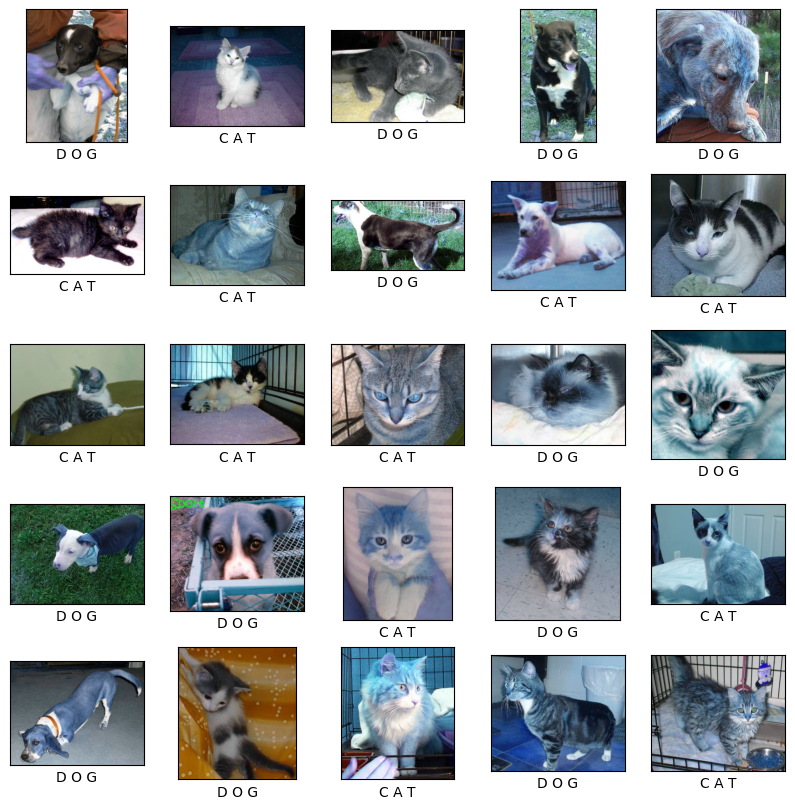

In [15]:
try_network(DIR + "/" + "test")

How good was the recognition test? If not so good, do not worry! another model layout or more training will improve it. The aim of this assigment is not to train a super accurrated network. 

### 4. The Hubel and Wiesel Cat Experiment:

Let's load our saved model (although we already loaded it, but suppose this was a separated file):

In [24]:
json_file = open(DIR +"/"+ "model.weights.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
cat_brain = keras.models.model_from_json(loaded_model_json)

cat_brain.load_weights(DIR +"/"+ "model.weights.h5")
print("Loaded model from disk")

Loaded model from disk


Now, let's create our testing model for this experiment. This model will represent the cortex of our cat's brain (i.e the fisrt layer of our trained model). So, notice that the model will be added only one single layer: 

In [25]:
# Initialising the CNN
cortex = keras.models.Sequential()
# Convolution
cortex.add(keras.layers.Conv2D(32, (3, 3), input_shape = (50, 50, 3), activation = 'relu'))

We added only one layer because we want to evaluate the output of that layer (cortex), instead of the whole network or brain. Thus, we can see which neurons (in this first layer) are more excitable and what patterns get them excited. 

Next, we are going to transfer the weights of the first layer of our loaded model (brain's cortex of our cat) to this new single-layer model, so evaluating the single-layer model is equivalent to internally evaluating the cortex of the cat. We need to create a single-layer model and read its responses, because in the original model those internal values are not accessible (only the outputs of the final layer are):



In [26]:
#Your code (one line)
cortex.set_weights([cat_brain.layers[0].get_weights()[0], cat_brain.layers[0].get_weights()[1]])

This code counts how many times each neuron (in the cortex) gets excited with the images in dir 'D:/all/test':

In [27]:
# Try all the test images (8495) in 'D:/all/test', one by one, with the 'cortex' model (e.g. cortex.predict(img)) 
# and find out, for each image, which neuron of the model was activated or responded 
# with the highest value (the most excited or exitable neuron). 
# For each neuron, keep counting how many times it was the most excited or exitable. 
# So that when you finish testing all the test images, you can rank the neurons 
# by the number of times they got to be the most excited.
# Remember that the output of the 'cortex' model for one single image is of size (1,48,48,32). 
#---------------------------------------------------------------------------------------------------------------------


# Handling all 8495 images is computationally expensive, so I will select a random subsample instead.
test_dir = DIR + "/" + "test"
neuron_counts = np.zeros((48, 48, 32), dtype=int)  
num_images_to_process = 8495

all_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
#selected_images = random.sample(all_images, min(num_images_to_process, len(all_images)))
selected_images = all_images 
for img_name in selected_images:
    img_path = os.path.join(test_dir, img_name)
    try:
        img = image.load_img(img_path, target_size=(50, 50))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  
        
        prediction = cortex.predict(img_array, verbose = 0)[0]  # Shape: (48, 48, 32)
        
        # Find the most excited neuron
        most_excited_neuron = np.unravel_index(np.argmax(prediction), prediction.shape)
        
        # Increment the count for this neuron
        neuron_counts[most_excited_neuron] += 1
    except Exception as e:
        print(f"Error processing image {img_name}: {str(e)}")
        continue

# Rank neurons by excitement count
ranked_neurons = np.argsort(-neuron_counts.ravel())
ranked_neurons_3d = [np.unravel_index(i, neuron_counts.shape) for i in ranked_neurons]

print("Neuron rankings based on excitement frequency:")
for rank, neuron in enumerate(ranked_neurons_3d[:20], 1):  # Print top 20 for brevity
    count = neuron_counts[neuron]
    if count > 0:
        print(f"Rank {rank}: Neuron at position {neuron} (excited {count} times)")

print(f"\nTotal images processed: {np.sum(neuron_counts)}")

Error processing image 4321.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4322.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4323.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4324.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4325.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4326.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4327.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4328.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 4329.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDEFD54E0>
Error processing image 433.jpg: cannot identify image file <_io.BytesIO o

This code finds the 4 most excited neurons in the cortex and create, for each, a blank visual field image with a dot (3x3) in its position: 

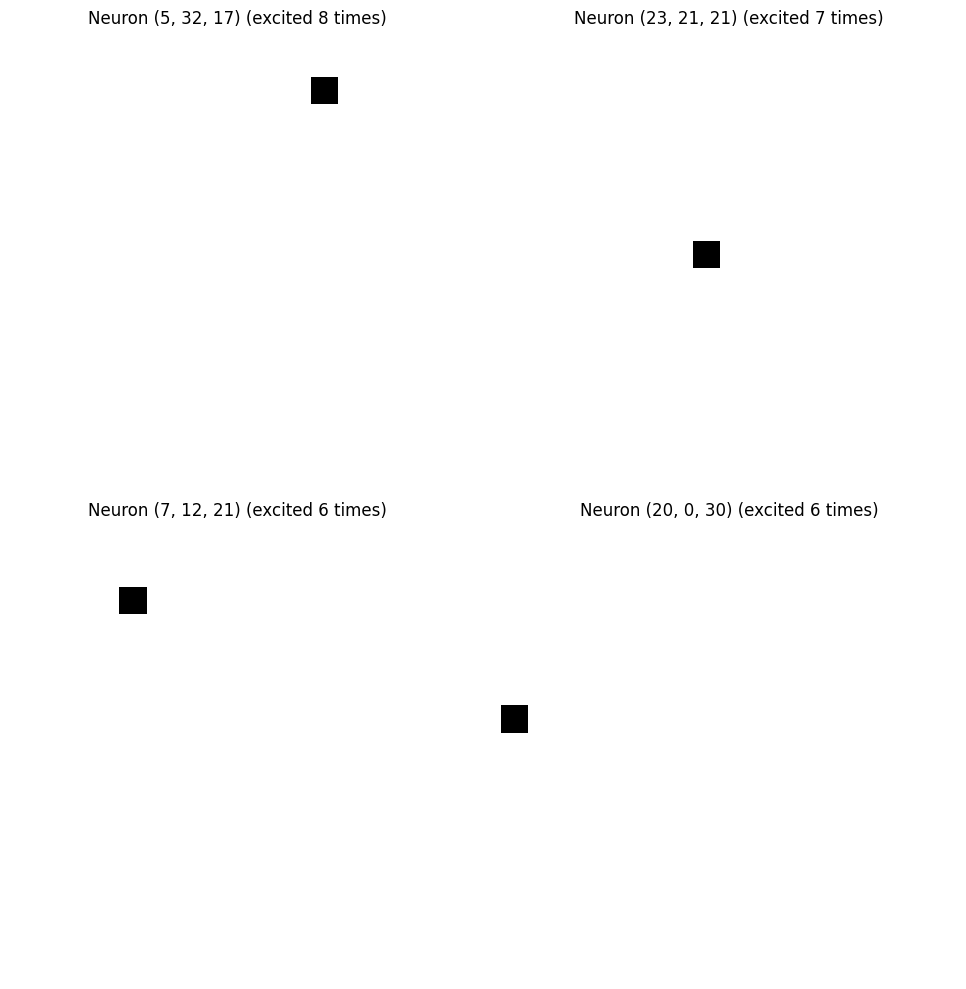

In [28]:
# Find the four neurons (in the ranking) that managed to be the most excited neuron, most times during the test.
# Build four 50x50 blank images, one for each field of view of the four most excited neurons during the test. 
# For each image, place a 3x3 black patch right at the position 
# where its associated neuron lies within the layer of the model 'cortex'.
#------------------------------------------------------------------------------------------------------------------

# Get the top four neurons
top_four_neurons = ranked_neurons_3d[:4]

# Build four 50x50 blank images for each of the top four neurons
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

for i, neuron in enumerate(top_four_neurons):
    blank_image = np.ones((50, 50, 3))  # White background
    
    # Calculate the position of the 3x3 patch
    # Map from 48x48 to 50x50
    x = int(neuron[0] * 50 / 48)
    y = int(neuron[1] * 50 / 48)
    
    # Place a 3x3 black patch
    blank_image[x:x+3, y:y+3] = 0  # Black patch
    
    axs[i].imshow(blank_image)
    axs[i].set_title(f"Neuron {neuron} (excited {neuron_counts[neuron]} times)")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# For each of the four neurons, collect six 3x3 patches, 
# from any six test images that have caused the neuron to be the most excited.
#------------------------------------------------------------------------------------------------------------------

test_dir = DIR + "/" + "test"
top_four_neurons = ranked_neurons_3d[:4]  # Use the top 4 neurons

neuron_patches = {tuple(neuron): [] for neuron in top_four_neurons}

for neuron in top_four_neurons:
    y, x, _ = neuron
    print(f"Processing neuron {neuron}")
   
    all_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
    random.shuffle(all_images)
   
    for img_name in all_images:
        if len(neuron_patches[tuple(neuron)]) >= 6:
            break
       
        img_path = os.path.join(test_dir, img_name)
        try:
            img = image.load_img(img_path, target_size=(50, 50))
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
           
            activations = cortex.predict(img_array, verbose=0)[0]
           
            if np.unravel_index(np.argmax(activations), activations.shape) == neuron:
                y_start, x_start = int(y * 50 / 48), int(x * 50 / 48)
                patch = img_array[0, y_start:y_start+3, x_start:x_start+3, :]
                neuron_patches[tuple(neuron)].append(patch)
               
        except Exception as e:
            print(f"Error processing image {img_name}: {str(e)}")

# Debug information
for neuron, patches in neuron_patches.items():
    print(f"Neuron {neuron}: {len(patches)} patches")
    for i, patch in enumerate(patches):
        print(f"  Patch {i} shape: {patch.shape}")

Processing neuron (5, 32, 17)
Error processing image 4330.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBD7A9C130>
Error processing image 6387.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDF074EA0>
Error processing image 6388.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBD9B7C680>
Error processing image 6393.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDF0D9710>
Error processing image 637.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBD9CE0BD0>
Error processing image 4333.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBD352B6A0>
Error processing image 4328.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBDFAF6890>
Error processing image 4322.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBD5A2ACF0>
Error processing image 5952.jpg: cannot identify image file <_io.BytesIO object at 0x000001DBD373AE30>
Error processing image 5951.jpg: cannot iden

This code finds the patches that excited the most excited neurons:

Let's plot the results:

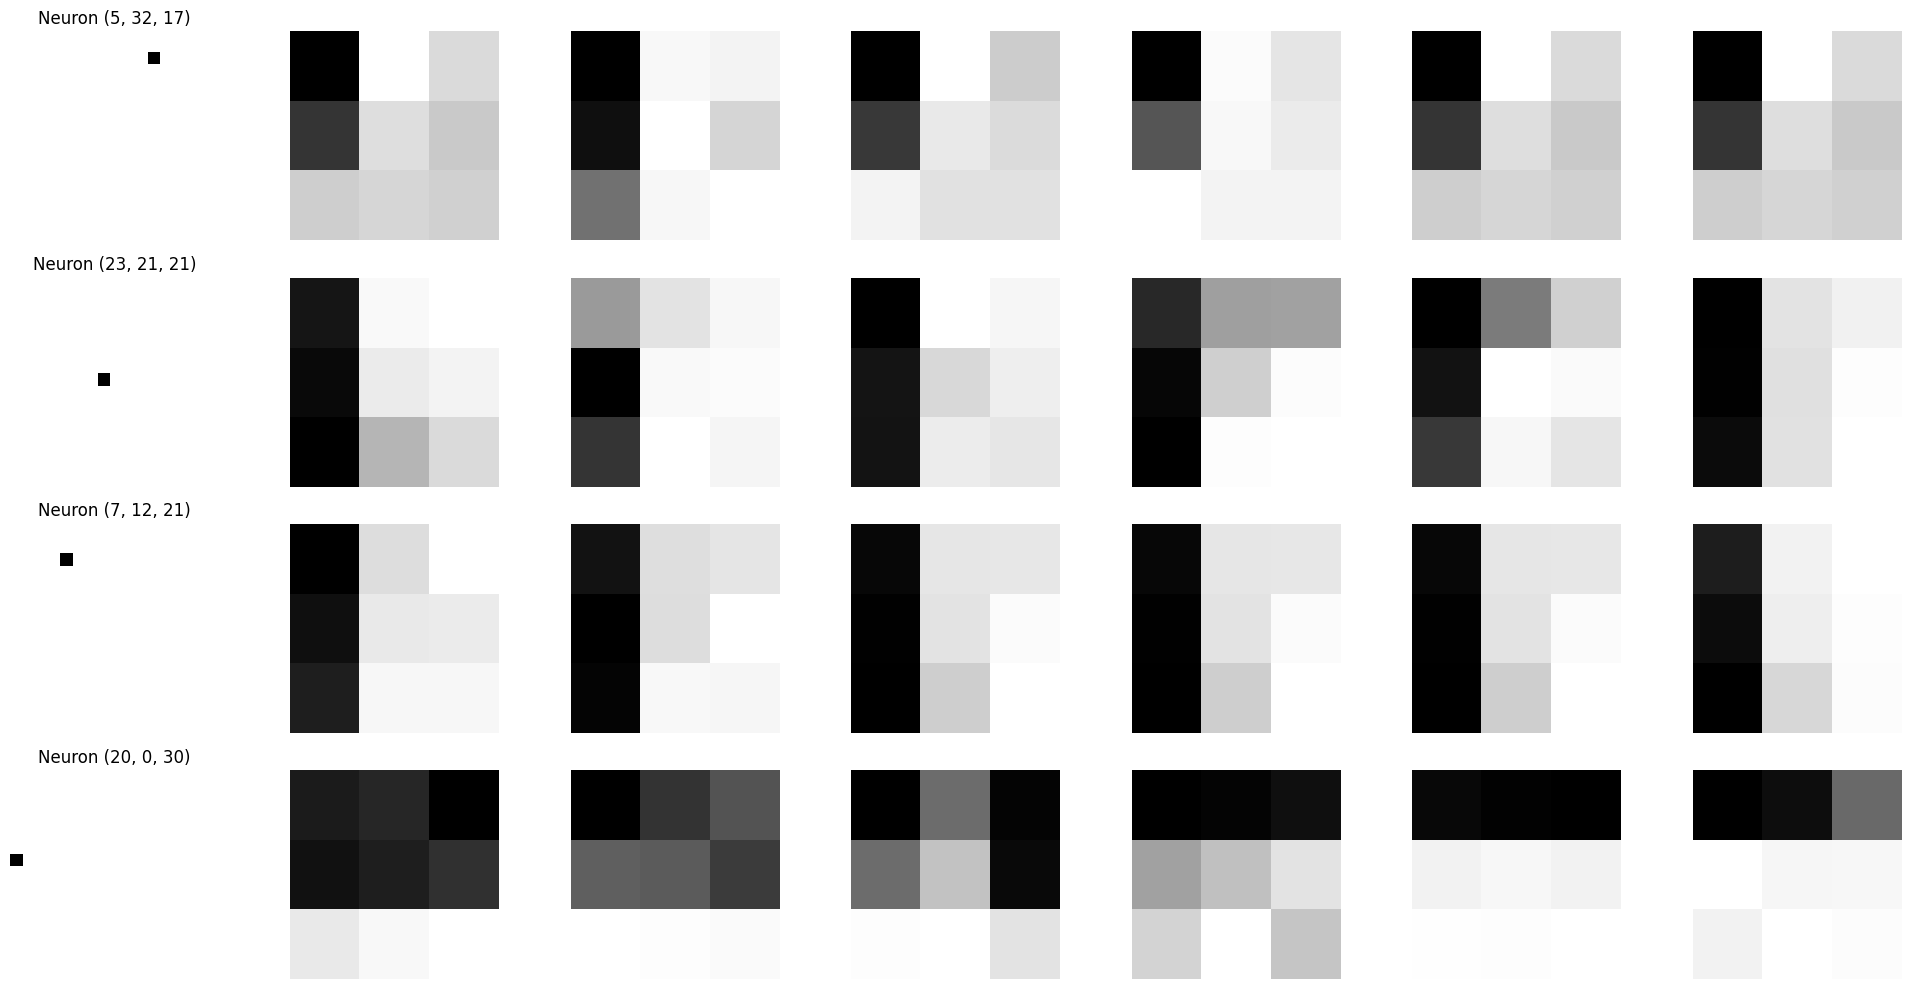

In [31]:
# plot all the calculations above, so your output image will resemble the one below:   
fig, axs = plt.subplots(4, 7, figsize=(20, 10))

for i, neuron in enumerate(top_four_neurons):
    # First column: Neuron field of view
    blank_image = np.ones((50, 50))
    y, x, _ = neuron
    y_scaled = int(y * 50 / 48)
    x_scaled = int(x * 50 / 48)
    blank_image[y_scaled:y_scaled+3, x_scaled:x_scaled+3] = 0
    axs[i, 0].imshow(blank_image, cmap='gray')
    axs[i, 0].set_title(f"Neuron {neuron}")
    axs[i, 0].axis('off')

    # Next 6 columns: Patches that excited this neuron
    patches = neuron_patches.get(tuple(neuron), [])
    for j in range(6):
        ax = axs[i, j+1]
        if j < len(patches):
            patch = patches[j]
            if patch is not None and patch.size > 0:
                if patch.shape[-1] == 3:
                    patch = np.mean(patch, axis=-1)
                ax.imshow(patch, cmap='gray')
            else:
                ax.text(0.5, 0.5, 'Empty patch', ha='center', va='center')
        else:
            ax.text(0.5, 0.5, 'No patch', ha='center', va='center')
        ax.axis('off')

plt.tight_layout()
plt.show()

In the figure above, rows represent info about the (4) most excitable neurons in the cortex. First column is the visual field (a blank 50x50 pixel image) with a black dot (actually a 3x3 pixel dot) placed over the patch associated to the respective neuron (which is actually the position of the neuron in the layer). The rest of the columns are examples of the same patch (zoomed in) at the moment when it got the neuron firing (i.e. when the activation pattern that excites the neuron showed up in the patch). Notice how the 6 patterns in each row are consistent (almost equal), this is, the neuron responds only to a specific stimulus in its associated patch, as Hubel and Wiesel discovered in real cats. 

# Summary :

To summarize, just as Hubel and Wiesel found that different neurons respond to different types of visual stimulations, this analysis revealed that different artificial neurons in the CNN are sensitive to different visual features in the dog and cat images.
Also, by focusing on the first layer, we are examining the earliest stages of visual processing in our artificial network, similar to how Hubel and Wiesel focused on early visual areas in the brain.
Therefore machine learning techniques can be used to model and understand principles of neuroscience, bridging the gap between biological and artificial neural networks.